In [12]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path  

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [3]:
def pullData(filename,date_col):
    filepath = Path(filename)
    df = pd.read_csv(filepath) 
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

In [4]:
dsbysite = pullData('..\AggregatedData\ZTE_CallAccess_FDD.csv','datetime')
dsbysite.head(5)

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to ENB Admission Failure(times),Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times),Number of mo-VoiceCall RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to ENB Admission Failure(times),Number of Mt-Access RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),Number of Successful Mo-Signalling RRC Establishment(times),...,Number of Cell DRB Admission Failure due to PHY Resource Allocated Failure(times),Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit),SiteCode
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-31 00:00:00,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.125,0.208333,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,6.083333,16.250000,1.916667,PAF003
2023-01-31 01:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,5.041667,10.041667,1.583333,PAF003
2023-01-31 02:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,5.000000,10.000000,1.958333,PAF003
2023-01-31 03:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,4.458333,7.166667,1.458333,PAF003
2023-01-31 04:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,4.500000,7.250000,1.666667,PAF003


### Basic Functions for Data Preparations
-  Feature Selction
-  Missing Values Filling
-  Data Normalization
-  Seasonal decomposition - rollingAvg

In [5]:
def remove_high_corr_features(df,threshold_in, plotCorrelationMatrix = False):
    # calculate the correlation matrix
    corr_matrix = df.corr()

    # create a mask to ignore the diagonal elements of the correlation matrix
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    # plot the correlation matrix
    if(plotCorrelationMatrix == True):
        sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm')

    # select features with high correlation coefficients
    high_corr_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold_in:
                colname = corr_matrix.columns[i]
                high_corr_features.add(colname)
            
            
    # drop the highly correlated features from the dataset
    return df.drop(high_corr_features, axis=1)


# Normalized Values with StandardScaler or MinMaxScaler
# Use the VarianceThreshold feature_selection to remove all low-variance features.
def remove_low_variance_features(df,threshold_in):
    #print(.140 * (1 - .140))
    df  = df.copy()
    features = df.columns
    
    sel = VarianceThreshold(threshold=threshold_in) 
    x = sel.fit_transform(df)
    
    # Get the indices of the selected features
    selected_indices = sel.get_support(indices=True)
        
    # Get the names of the selected features
    selected_features = df.columns[selected_indices]
   
    #low_variance_features = intersection(features,selected_features)
    low_variance_features = set(features)-set(selected_features)
    
    #print('{} - {}'.format(len(features),len(selected_features)))
    #print(len(low_variance_features))
    
    # drop the highly correlated features from the dataset
    return df.drop(low_variance_features, axis=1)


def fillNa(df,rolling_window):
    df = df.copy()
   
    # Show the rows with NAN values
    nan_rows = df[df.isnull().any(axis=1)]
    
    while(nan_rows.shape[0] > 0):
        # Use transform to fill null values with the rolling mean of the corresponding group
        df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
        nan_rows = df[df.isnull().any(axis=1)]
           
        # Fill null values with zeros
        #dset = dset.fillna(-999)
        # dset = dset.dropna()
    return df

def normalizedValues(df,scaler):
    df = df.copy()
    #scaler = StandardScaler()
    #scaler = MinMaxScaler((0, 1))
    # Min Max Scaler
    ts = scaler.fit_transform(df)

    lables = df.columns
    for i in range(len(lables)):
        df[lables[i]] = ts.T[i]
    
    return df

def rollingAvg(df,rolling_window):
    df = df.copy()
    df = df.rolling(window=rolling_window).mean()
    #df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
    df = df.dropna()
    return df  

# Check for missing values
def getMissingValues(df):
    columns_missing_values = {}
    for c in df.columns:
        msv = df[df[c].isna()| df[c].eq(' ')].shape[0]
        if msv > 0:
            columns_missing_values[c] = (msv,msv/df.shape[0]*100)
    return columns_missing_values

In [8]:
def splitData(df,train_pct = 0.7):
    
    # get the unique dates from the index
    unique_days = pd.Series(df.index.date).unique()
    
    # calculate the number of rows for the training set
    train_size = int(len(unique_days) * train_pct)
    print(train_size)
        
    # calculate the end time of the training set
    train_end_time = df.index.min() + pd.Timedelta(train_size, unit="d")
    print(train_end_time)
    
    # separate the dataframe into training and testing sets
    train_df = df.loc[:train_end_time]
    test_df = df.loc[train_end_time + pd.Timedelta(hours=1):]
    
    return train_df,test_df

### Data Preprocessing

In [15]:
dfdata = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy() #LIM090 LIM003 PAF024
dfdata = dfdata.drop('SiteCode', axis=1)
dfdata = fillNa(dfdata,24)

dfdata = remove_low_variance_features(dfdata,0.05)
print(dfdata.shape)
dfdata = remove_high_corr_features(dfdata,0.999)
print(dfdata.shape)

(1176, 64)
(1176, 46)


In [16]:
dfdata = normalizedValues(dfdata,StandardScaler()) # MinMaxScaler(feature_range=(0, 1)))
train_data,test_data = splitData(dfdata,0.7)

34
2023-03-06 00:00:00


# LSTM
LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems.

## Detecting Past Anomalies:

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [24]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Normalize the data using MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#train_values = scaler.fit_transform(train_data.values)
#test_values = scaler.transform(test_data.values)

# Define the number of time steps and features
time_steps = 24
num_features = train_data.shape[1]

# Prepare the data for training the LSTM model
def prepare_data(data, time_steps):
    # Define the training and testing inputs and targets
    x, y = [], []

    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i, :])
        y.append(data[i, 0])
        
    return np.array(x), np.array(y)
############### prepare_data

train_x, train_y = prepare_data(train_data.values,time_steps)
test_x, test_y =  prepare_data(test_data.values, time_steps)

# Step 3: Define a baseline
# Train LSTM autoencoder to learn normal behavior
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(time_steps, num_features), return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False, dropout=0.0)) 
model.add(Dense(num_features))
model.compile(optimizer='adam', loss='mse')
model.fit(train_x,train_y, epochs=30, batch_size=64, validation_split=0.1)

# Evaluate the model on the testing data
test_loss = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', test_loss)

#Test loss: 0.07953566312789917

Epoch 1/30
12/12 [==============================] - 10s 388ms/step - loss: 1.7535 - val_loss: 0.0131
Epoch 2/30
12/12 [==============================] - 4s 292ms/step - loss: 1.5575 - val_loss: 0.0118
Epoch 3/30
12/12 [==============================] - 4s 313ms/step - loss: 1.4399 - val_loss: 0.0090
Epoch 4/30
12/12 [==============================] - 4s 333ms/step - loss: 0.9652 - val_loss: 0.0127
Epoch 5/30
12/12 [==============================] - 4s 347ms/step - loss: 0.7615 - val_loss: 0.0054
Epoch 6/30
12/12 [==============================] - 4s 353ms/step - loss: 0.8519 - val_loss: 0.0365
Epoch 7/30
12/12 [==============================] - 5s 387ms/step - loss: 1.3178 - val_loss: 0.0072
Epoch 8/30
12/12 [==============================] - 4s 346ms/step - loss: 1.0457 - val_loss: 0.0127
Epoch 9/30
12/12 [==============================] - 4s 340ms/step - loss: 0.6486 - val_loss: 0.0214
Epoch 10/30
12/12 [==============================] - 4s 341ms/step - loss: 0.4063 - val_loss: 0.011

In [25]:
# Detect anomalies using reconstruction error
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

train_pred = pd.DataFrame(train_pred, columns= train_data.columns, index=train_data[time_steps:].index)
test_pred = pd.DataFrame(test_pred, columns= test_data.columns, index=test_data[time_steps:].index)



11/11 [==============================] - 1s 86ms/step


In [28]:
def find_boundaries(df, variable,q1=0.01,q2=0.99):
    # the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary

def get_outliers(df,variable,q1=0.01,q2=0.99):
    outlier = df.copy()
    upper_boundary,lower_boundary =  find_boundaries(df,variable,q1,q2)
    print('{}-{}'.format(upper_boundary,lower_boundary))
    outlier  = outlier.loc[(outlier[variable] < lower_boundary)|(outlier[variable] > upper_boundary)]
    #outlier[variable] = np.where(outlier[variable] > upper_boundary, upper_boundary,
    #                   np.where(outlier[variable] < lower_boundary, lower_boundary, outlier[variable]))
    return outlier

col = train_data.columns[8]
print(col) #e.g. 'Maximum Number of RRC Connection User(unit)'
outliers = get_outliers(train_pred,col,0.0009,0.99)
outliers = pd.concat([outliers, get_outliers(test_pred,col)], axis=0)
outliers.index

Number of Successful Context Modify (times)
6.763266391754224--0.22548457787036896
0.41239490568637965--0.3447502249479294


DatetimeIndex(['2023-02-16 18:00:00', '2023-02-26 00:00:00',
               '2023-02-26 01:00:00', '2023-02-26 18:00:00',
               '2023-02-26 19:00:00', '2023-02-26 20:00:00',
               '2023-02-26 21:00:00', '2023-02-26 22:00:00',
               '2023-02-26 23:00:00', '2023-03-10 22:00:00',
               '2023-03-10 23:00:00', '2023-03-11 00:00:00',
               '2023-03-11 01:00:00', '2023-03-19 14:00:00',
               '2023-03-19 15:00:00', '2023-03-19 16:00:00',
               '2023-03-19 17:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

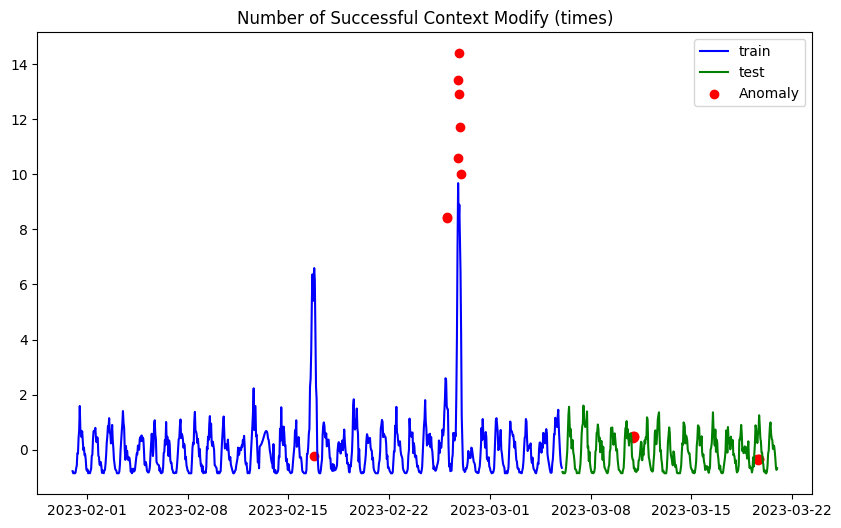

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_data.index, train_data[col], color='blue', label = 'train')
ax.plot(test_data.index, test_data[col], color='green', label = 'test')
#ax.plot(train_data[3:].index,train_pred.T[3], color='red', label = 'train_pred')
#ax.plot(test_data[3:].index,test_pred.T[3], color='red', label = 'test_pred')
ax.scatter(outliers.index,outliers[col], color='red', label = 'Anomaly')
plt.title(col)
plt.legend()
plt.show();


### Tuning Hyperparameter

In [23]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Set random seed for reproducibility
tf.random.set_seed(42)

# Normalize the data using MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#train_values = scaler.fit_transform(train_data.values)
#test_values = scaler.transform(test_data.values)

# Define the number of time steps and features
time_steps = 24
num_features = train_data.shape[1]

# Prepare the data for training the LSTM model
def prepare_data(data, time_steps):
    # Define the training and testing inputs and targets
    x, y = [], []

    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i, :])
        y.append(data[i, 0])
        
    return np.array(x), np.array(y)
############### prepare_data

train_x, train_y = prepare_data(train_data.values,time_steps)
test_x, test_y =  prepare_data(test_data.values, time_steps)


# Define the LSTM model
def create_lstm(units, dropout):
    model = Sequential()
    model.add(LSTM(units, input_shape=(time_steps, num_features), dropout=dropout, return_sequences=True))
    model.add(LSTM(units, dropout=dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define the hyperparameters to search over
param_grid = {
    'units': [32, 64, 128],
    'dropout': [0.0, 0.1, 0.2]
}

# Create the grid search object
lstm = KerasRegressor(build_fn=create_lstm, epochs=10, batch_size=64, verbose=0)
grid_search = GridSearchCV(estimator=lstm, param_grid=param_grid, scoring=make_scorer(mean_squared_error), cv=3)

# Fit the grid search object to the data
grid_search.fit(train_x, train_y)

# Print the best hyperparameters and model performance
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

C:\Users\GeorgiosCh\AppData\Local\Temp\2\ipykernel_2468\2117248202.py:53: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm = KerasRegressor(build_fn=create_lstm, epochs=10, batch_size=64, verbose=0)


Best parameters: {'dropout': 0.0, 'units': 128}
Best score: 2.078119949922407
